In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import os


In [2]:
%%time

# Loads filenames, images and labels 
# Reshapes images to (80, 80, 3)

def load_data(name):
    df = pd.read_csv(name + '.csv')
    df_sorted = df.sort_values(by='image_id')

    labelDict = dict()
    labels = df_sorted.values
    for entry in labels:
        try:
            labelDict[entry[0]] = entry[1]
        except:
            labelDict[entry[0]] = 0

    images = []
    labels = []
    filenames = []
    for filename in os.listdir(name):
        if filename.endswith('.png'):
            file_path = os.path.join(name, filename)
            image = Image.open(file_path)
            image_array = np.array(image)
            if filename[:-4] in labelDict.keys():
                filenames.append(filename[:-4])
                images.append(image_array)
                labels.append(labelDict[filename[:-4]])

    for i in range(len(images)):
        if images[i].shape != (80, 80, 3):
            images[i] = np.stack((images[i], images[i], images[i]), axis=-1)

    images = np.array(images)
    labels = np.array(labels)

    return filenames, images, labels

training_filenames, training_images, training_labels = load_data("train")
print(f"Training: {np.shape(training_images)} - {np.shape(training_labels)}")

validation_filenames, validation_images, validation_labels = load_data("validation")
print(f"Validation: {np.shape(validation_images)} - {np.shape(validation_labels)}")

test_filenames, test_images, test_labels = load_data("test")
print(f"Test: {np.shape(test_images)} - {np.shape(test_labels)}")

Training: (10500, 80, 80, 3) - (10500,)
Validation: (3000, 80, 80, 3) - (3000,)
Test: (4500, 80, 80, 3) - (4500,)
CPU times: user 4.77 s, sys: 966 ms, total: 5.74 s
Wall time: 7.42 s


In [3]:
def print_images(images, labels, count, cmap=None, title="title"):
    for i in range(count):
        plt.imshow(images[i], cmap=cmap)
        plt.title(f'Label: {labels[i]}')
        plt.show()

        img = images[i]
        # mins = np.min(img, axis=(0, 1))
        # maxs = np.max(img, axis=(0, 1))
        # img = (img - mins) / (maxs - mins) * 255.0
        Image.fromarray(img.astype(np.uint8)).save(f"documentation/plots/{title}-{labels[i]}-{str(i)}.png")

In [4]:
# Standardize images

standard_training_images = (training_images - np.mean(training_images, axis=(0, 1, 2))) / np.std(training_images, axis=(0, 1, 2))
standard_validation_images = (validation_images - np.mean(validation_images, axis=(0, 1, 2))) / np.std(validation_images, axis=(0, 1, 2))
standard_test_images = (test_images - np.mean(test_images, axis=(0, 1, 2))) / np.std(test_images, axis=(0, 1, 2))

In [ ]:
print_images(standard_training_images, training_labels, 5, title="standard")

In [18]:
def to_grayscale(images):
    return np.mean(images, axis=(3))

gray_training_images = to_grayscale(training_images)
gray_validation_images = to_grayscale(validation_images)
gray_test_images = to_grayscale(test_images)

In [ ]:

print_images(gray_training_images, training_labels, 5, cmap='gray', title="gray")

In [ ]:
# Keep only the strongest color for each pixel
def keep_strongest_color(rgb) :
    c = np.argmax(rgb)
    for i in range(3):
        if i != c:
            rgb[i] = 0
    return rgb

def process_images(images):
    for i in range(len(images)):
        if i % 100 == 0:
            print(i)
        for j in range(len(images[i])):
            for k in range(len(images[i][j])):
                images[i][j][k] = keep_strongest_color(images[i][j][k])
    return images
mono_training_images = process_images(training_images)
mino_validation_images = process_images(validation_images)
mono_test_images = process_images(test_images)
    

In [ ]:

print_images(mono_training_images, training_labels, 5, title="mono")

In [41]:
%%time
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
flat_training_images = scaler.fit_transform(mono_training_images.reshape((10500, 80*80*3)))
flat_validation_images = scaler.fit_transform(mino_validation_images.reshape((3000, 80*80*3)))


from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(flat_training_images, training_labels)
score = str(mnb.score(flat_validation_images, validation_labels))
print("score on test: " + str(score))

score on test: 0.3933333333333333
CPU times: user 3.26 s, sys: 1.99 s, total: 5.25 s
Wall time: 2.21 s


In [42]:
%%time
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import skimage.measure

reduced_training_images = (skimage.measure.block_reduce(gray_training_images, (1,2,2), np.max)).reshape((10500, 40*40))
print(np.shape(reduced_training_images))
reduced_validation_images = (skimage.measure.block_reduce(gray_validation_images, (1,2,2), np.max)).reshape((3000, 40*40))

clf = svm.SVC(decision_function_shape='ovr', verbose=True, max_iter=-1, kernel="rbf", C=1)
clf.fit(reduced_training_images, training_labels)
score = clf.score(reduced_validation_images, validation_labels)

print("score on test: " + str(score))

(10500, 1600)
[LibSVM].....*.*
optimization finished, #iter = 6663
obj = -4235.693657, rho = -0.311302
nSV = 6020, nBSV = 4463
.....*.*
optimization finished, #iter = 6997
obj = -4191.494838, rho = -0.251943
nSV = 6009, nBSV = 4334
.....*..*
optimization finished, #iter = 7055
obj = -4523.130358, rho = 0.156289
nSV = 6230, nBSV = 4623
Total nSV = 9918
score on test: 0.505
CPU times: user 1min 49s, sys: 257 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model_train_images = np.reshape(gray_training_images, (10500, 80, 80, 1))
model_train_labels = to_categorical(training_labels, num_classes=3)
model_validation_images = np.reshape(gray_validation_images, (3000, 80, 80, 1))
model_validation_labels = to_categorical(validation_labels, num_classes=3)

trainining_datagen = ImageDataGenerator(
    # rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)
trainining_datagen.fit(model_train_images)


my_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])
my_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

history = my_model.fit(
    trainining_datagen.flow(model_train_images, model_train_labels, batch_size=32),
    epochs=50,
    validation_data=(model_validation_images, model_validation_labels),
)

loss, accuracy = my_model.evaluate(model_validation_images, model_validation_labels)
print(f'Validation accuracy: {accuracy}')

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 78, 78, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 39, 39, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 37, 37, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,235 (1.22 MB)

 Trainable params: 319,235 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.3491 - loss: 2.6127 - val_accuracy: 0.3960 - val_loss: 1.0905
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4033 - loss: 1.0835 - val_accuracy: 0.3953 - val_loss: 1.0892
Epoch 3/50
 85/329 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4005 - loss: 1.0719

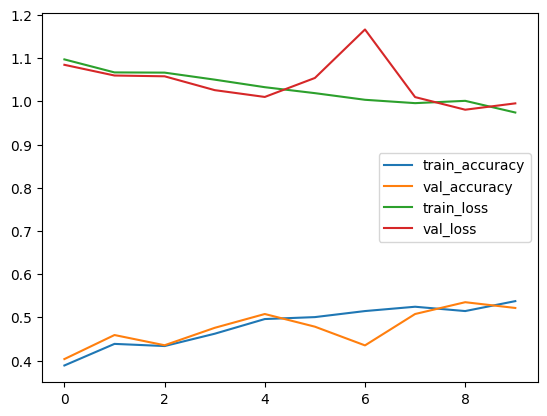

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig("documentation/plots/cnn-1")
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(model, images, labels):
    y_prediction = model.predict(images)
    y_prediction = np.argmax (y_prediction, axis = 1)
    result = confusion_matrix(labels, y_prediction , normalize='pred')
    print(result)

print_confusion_matrix(my_model, validation_images, validation_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[0.55072464 0.31189948 0.22222222]
 [0.21014493 0.34552846 0.38888889]
 [0.23913043 0.34257206 0.38888889]]
